<center>
<img src=\"../../img/ods_stickers.jpg\">
# Открытый курс по машинному обучению
<center>Автор: Борисов Артём (@amphyby)
<center>
## Знакомимся с Microsoft Cognitive Toolkit

### Немного общих слов

Существует много Deep Learning фреймворков от различных именитых компаний. Часть из них хорошо известны в open source сообществе, часть - чуть менее известны. <img src="../../img/DLframeworks.png">
Суть проста: не TensorFlow единым сыт дата-сатанист. Этот материал посвящен ознакомлению читателя с DL фреймворком Microsoft Cognitive Toolkit (cntk в простонародье). Помимо того, что он лежит в open-source чуть менее, чем полностью, при расчетах на 2х и более GPU он на раз-два обходит Tensorflow по производительности. Поддерживается и развивается фреймворк подразделением Microsoft Research, а из примеров использования в проде первым приходит на ум поисковик Bing.

Использовать cntk можно из powershell, c#, c++, и конечно же python (вроде еще из жавы, но это не точно). CNTK есть под Linux и Windows, для Mac OS на данный момент можно только docker-образ с CNTK посоветовать. Установка, при использовании только из python, сводится к элементарному:
**pip install https://cntk.ai/PythonWheel/CPU-Only/cntk-2.4-cp36-cp36m-win_amd64.whl**
Существует большой выбор разных сборок для версий py2/py3 и использования на CPU(intel)/GPU(nvidia)/GPU-1bit-quantized-SGD(для магистров черной магии).

### Поехали!
Знакомиться с CNTK будем на примере классификации классического (для примеров классификации изображений) датасета рукописных цифр MNIST. Cразу заимпортим, всё что обещает пригодиться в рамках блокнота:

In [1]:
import cntk
cntk.__version__

'2.4'

In [2]:
import os
# Зададим желаемое целевое устройство для расчетов:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        cntk.device.try_set_default_device(cntk.device.cpu())
#    else:
#        cntk.device.try_set_default_device(cntk.device.gpu(0))
# В моем случае это только процессор

In [3]:
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import shutil
import struct
import sys
from urllib.request import urlretrieve

%matplotlib inline

Опишем функции для загрузки самого датасета. Он состоит из 60000 тренировочных картинок и 10000 тестовых. Каждая картинка - черно-белая, размером 28x28px. Т.е. каждая запись датасета это список из (28*28=) 784элементов со значениями, соответствующими оттенкам серого (у нас их аж 256 - Э.Л.Джеймс бы обзавидовалась) плюс 1 значение метки.

In [4]:
def loadData(src, cimg):
    print ('Идёт загрузка ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Загрузка завершена.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # проверяем "магическое" число из первых байтов файла
            if n[0] != 0x3080000:
                raise Exception('Invalid file: unexpected magic number.')
            # считываем количество записей
            n = struct.unpack('>I', gz.read(4))[0]
            if n != cimg:
                raise Exception('Invalid file: expected {0} entries.'.format(cimg))
            crow = struct.unpack('>I', gz.read(4))[0]
            ccol = struct.unpack('>I', gz.read(4))[0]
            if crow != 28 or ccol != 28:
                raise Exception('Invalid file: expected 28 rows/cols per image.')
            # считываем данные в один очень длинный список
            res = np.fromstring(gz.read(cimg * crow * ccol), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, crow * ccol))

def loadLabels(src, cimg):
    print ('Идёт загрузка ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Загрузка завершена.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # проверяем "магическое" число из первых байтов файла
            if n[0] != 0x1080000:
                raise Exception('Invalid file: unexpected magic number.')
            # считываем количество записей
            n = struct.unpack('>I', gz.read(4))
            if n[0] != cimg:
                raise Exception('Invalid file: expected {0} rows.'.format(cimg))
            # считываем метки
            res = np.fromstring(gz.read(cimg), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, 1))

def try_download(dataSrc, labelsSrc, cimg):
    data = loadData(dataSrc, cimg)
    labels = loadLabels(labelsSrc, cimg)
    return np.hstack((data, labels))

Скачаем данные:

In [5]:
# URL-ы обучающей выборки
url_train_image = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_train_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
num_train_samples = 60000

print("Загрузка обучающей выборки")
train = try_download(url_train_image, url_train_labels, num_train_samples)

# URL-ы тестовой выборки
url_test_image = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
url_test_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
num_test_samples = 10000

print("Загрузка тестовой выборки")
test = try_download(url_test_image, url_test_labels, num_test_samples)

Загрузка обучающей выборки
Идёт загрузка http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Загрузка завершена.
Идёт загрузка http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Загрузка завершена.
Загрузка тестовой выборки
Идёт загрузка http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Загрузка завершена.
Идёт загрузка http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Загрузка завершена.


Проверим, что всё скачалось и в том формате, в котором мы ожидаем:

In [6]:
np.shape(train)

(60000, 785)

In [7]:
np.shape(test)

(10000, 785)

Полюбуемся на случайный экземпляр обучающей выборки:

Метка:  9


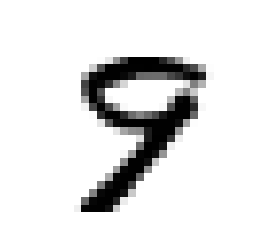

In [8]:
sample_number = np.random.randint(60000)
plt.imshow(train[sample_number,:-1].reshape(28,28), cmap="gray_r")
plt.axis('off')
print("Метка: ", train[sample_number,-1])

In [9]:
# Сохранение данных в формате совметимом с функционалом CNTK text reader
def savetxt(filename, ndarray):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Сохраняется ", filename )
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(10, dtype=np.uint).astype(str)))
            for row in ndarray:
                row_str = row.astype(str)
                label_str = labels[row[-1]]
                feature_str = ' '.join(row_str[:-1])
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("Такой файл уже существует", filename)

In [10]:
data_dir = os.path.join("..", "Image", "DataSets", "MNIST")
if not os.path.exists(data_dir):
    data_dir = os.path.join("data", "MNIST")

print ('Идёт запись файла...')
savetxt(os.path.join(data_dir, "Traincntk.txt"), train)

print ('Идёт запись файла...')
savetxt(os.path.join(data_dir, "Testcntk.txt"), test)

print('Выполнено')

Идёт запись файла...
Сохраняется  data\MNIST\Traincntk.txt
Идёт запись файла...
Сохраняется  data\MNIST\Testcntk.txt
Выполнено


Сохраним данные обучающей и тестовой выборок. У этого действа есть две причины, первая это банальное нежелание лишний раз загружать данные в блокноте при прогоне функционала CNTK. Вторая причина: при всей простоте использования данных в формате NumPy/SciPy/Pandas считывая их же reader-ами, это применимо к разве что небольшим наборам данных, т.к. глубокое обучение как правило требует больших объемов данных - стОит продемонстрировать работу встроенных CNTK-шных reader-ов, которые успешно масштабируются на случай терабайтов данных. Фомат файлов немного напоминает Vowpal Wabbit-овский:

    |labels 0 0 0 1 0 0 0 0 0 0 |features 0 0 0 0 ... 
                                               (784 интов по одному на каждый пиксель)
Ниже представлена функция "create_reader" для чтения сохранненых выше обучающей и тестовой выборок.

In [11]:
def create_reader(path, is_training, dimens, num_label_classes):
    
    labelStream = cntk.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = cntk.io.StreamDef(field='features', shape=dimens, is_sparse=False)
    
    deserailizer = cntk.io.CTFDeserializer(path, cntk.io.StreamDefs(labels = labelStream, features = featureStream))
            
    return cntk.io.MinibatchSource(deserailizer,
       randomize = is_training, max_sweeps = cntk.io.INFINITELY_REPEAT if is_training else 1)

In [12]:
data_found = False

for data_dir in [os.path.join("..", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Traincntk.txt")
    test_file = os.path.join(data_dir, "Testcntk.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break

### Построение модели
Для классификации картинок будем использовать многоклассовую логистическую регрессию. <img src="../../img/NNmulticlassLR.png">
Число выходных узлов соответствует количеству значений, которое может принимать зависимая переменная. Каждый узел суммирования использует свой собственный набор весов для масштабирования входных функций и суммирования их вместе. Вместо того, чтобы передавать суммированный вывод взвешенных входных признаков через сигмоиду, выход пропускаем через [softmax][]-функцию, которая вдобвак к проецированию на отрезок [0;1] нормализует вывод выходных узлов.

[softmax]: https://ru.wikipedia.org/wiki/Softmax

In [13]:
# Для воспроизводимости результатов
np.random.seed(0)
cntk.cntk_py.set_fixed_random_seed(17)
cntk.cntk_py.force_deterministic_algorithms()

num_classes = 10
dimensions = 784

Логистическа регрессия являет собой простую линейную модель, принимающую на вход вектор $\bf\vec{x}$ из чисел, описывающих классифицируемый объект и вычисляющую признаки($\it\vec{z}$). Для каждой из 10 цифр существует вектор весов, соответствующий входным значениям пикселей. Итого 10 значений, 784 пикселя - наша матрица весов $\bf{W}$ имеет размерность 10x784. Конечно же не стОит забывать про вектор смещений $\bf\vec{b}$ длиной 10.
Таким образом первым делом мы вычисляем: $\it\vec{z}=\bf{W}\bf{\vec{x}}+\bf{\vec{b}}$ .
Признаки $\vec{z}$ еще не спроецированы на отрезок [0:1] сигмоидой, вместо этого результат нормализуется функцией [softmax][]: 

$$\dfrac{{e}^{{z}_{i}}}{\sum\limits_{j=0}^9 {{e}^{{z}_{i}}}}$$

и сумма пресказаний по всем классам становится равна 1. В CNTK при обучении будем использовать функцию, совмещающую **softmax** и функцию потерь **cross entropy error**.
[softmax]: https://ru.wikipedia.org/wiki/Softmax

Входная переменная (**input variable**) - является ключевым понятием CNTK. Под ней подразумевается контейнер, который мы наполняем некоторыми наблюдениями, в нашем случае пикселями картинки, во время обучения и тестирования. Таким образом, форма входной переменной должна соответствовать форме данных, которые будут предоставлены:

In [14]:
iv = cntk.input_variable(dimensions)
label = cntk.input_variable(num_classes)

### Настройка нейронной сети для логистической регрессии
В CNTK существует метод Dense, которая создает полносвязный слой выполняющий описанные выше операции взвешенного суммирования входных данных с добавлением смещения.

In [15]:
def create_model(features):
    with cntk.layers.default_options(init = cntk.glorot_uniform()):
        r = cntk.layers.Dense(num_classes, activation = None)(features)
        return r

будем использовать z для обозначения вывода нейронной сети:

In [16]:
# Переведем из [0;255] значения пикселей в [0;1]
input_s = iv/255
z = create_model(input_s)

### Обучение
Далее определим **функцию потерь**:

In [17]:
loss = cntk.cross_entropy_with_softmax(z, label)

Зададим метрику для оценки качества модели: будем использовать функцию classification_error(), которая возвращает среднее среди сопосталенных экземпляров.

In [18]:
le = cntk.classification_error(z, label)

### Тюнинг
Среди прочих, самым популярным способом уменьшить функцию потерь является стохастический градиентный спуск (SGD). Мы будем использовать mini-batch SGD - версию градиентного спуска, где на каждом шаге для обновления весов используется не один эземпляр, а несколько. Это дает преимущество, делая шаги менее зашумленными. При этом в процессе итерирования и обновления параметров модели, мы используем каждый раз новый пак образцов в нашем мини-батче. Как только инкрементные частоты ошибок перестают сильно меняться или после прохождения захардкоженного максимального числа минибатчей, используемых для обучения, мы говорим о натренированности модели.

In [19]:
learning_rate = 0.2
lr_schedule = cntk.learning_rate_schedule(learning_rate, cntk.UnitType.minibatch)
learner = cntk.sgd(z.parameters, lr_schedule)
trainer = cntk.Trainer(z, (loss, le), [learner])

In [20]:
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Минибатч: {0}, значение функции потерь: {1:.4f}, ошибка: {2:.2f}%".format(mb, training_loss, eval_error*100))
    return mb, training_loss, eval_error

### Запуск
Довольно разговоров! Давайте, наконец, запустим эту сеть!

In [21]:
minibatch_size = 64
num_samples_per_run = 60000
num_run_to_train_with = 20
num_minibatches_to_train = (num_samples_per_run * num_run_to_train_with) / minibatch_size

In [22]:
# Тот самый ридер, давно нами написанный, настал твой час
reader_train = create_reader(train_file, True, dimensions, num_classes)

# Отмапим потоки данных на входные переменные
input_map = {
    label  : reader_train.streams.labels,
    iv  : reader_train.streams.features
} 

# Обучим модель
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    
    # Прочитаем минибатч из обучающей выборки
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Минибатч: 0, значение функции потерь: 2.2886, ошибка: 84.38%
Минибатч: 500, значение функции потерь: 0.5097, ошибка: 14.06%
Минибатч: 1000, значение функции потерь: 0.2292, ошибка: 4.69%
Минибатч: 1500, значение функции потерь: 0.4281, ошибка: 15.62%
Минибатч: 2000, значение функции потерь: 0.1898, ошибка: 4.69%
Минибатч: 2500, значение функции потерь: 0.1821, ошибка: 7.81%
Минибатч: 3000, значение функции потерь: 0.1095, ошибка: 1.56%
Минибатч: 3500, значение функции потерь: 0.3147, ошибка: 12.50%
Минибатч: 4000, значение функции потерь: 0.3544, ошибка: 9.38%
Минибатч: 4500, значение функции потерь: 0.2468, ошибка: 4.69%
Минибатч: 5000, значение функции потерь: 0.2030, ошибка: 3.12%
Минибатч: 5500, значение функции потерь: 0.1313, ошибка: 3.12%
Минибатч: 6000, значение функции потерь: 0.1445, ошибка: 3.12%
Минибатч: 6500, значение функции потерь: 0.2800, ошибка: 9.38%
Минибатч: 7000, значение функции потерь: 0.1723, ошибка: 6.25%
Минибатч: 7500, значение функции потерь: 0.3104, ошибка

Давайте выведем на график ошибки среди всех различных минибатчей. Как и положено, в процессе обучения значение функции потерь падает, хотя и не без выбросов.

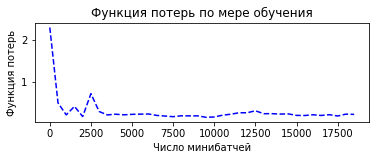

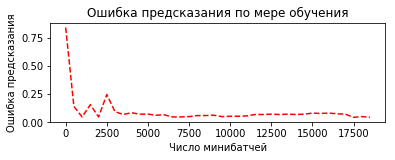

In [23]:
# Вычислим скользящую среднюю значений функции потерь
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Построим графики функции потерь и ошибки
plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Число минибатчей')
plt.ylabel('Функция потерь')
plt.title('Функция потерь по мере обучения')
plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Число минибатчей')
plt.ylabel('Ошибка предсказания')
plt.title('Ошибка предсказания по мере обучения')
plt.show()

Теперь давайте протестируем обученную нейронную сеть на тестовых данных. Это делается методом test_minibatch:

In [24]:
# Прочтем тестовые данные
reader_test = create_reader(test_file, False, dimensions, num_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    iv  : reader_test.streams.features,
}

# Параметры тестовых данных
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # Загружаем тестовую выборку минибатчами в соответствии с заданным test_minibatch_size
    # Каждый кусочек данных в минибатче - картинка цифры из 784пикселей
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Средняя ошибка на тестовой выборке по всем минибатчам
print("Средняя ошибка на тесте: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Средняя ошибка на тесте: 7.38%


До сих пор мы имели дело с совокупными мерами ошибки. Возьмем теперь вероятности, связанные с отдельными точками данных. Для каждого наблюдения функция eval возвращает распределение вероятности по всем классам. Всего классов по количеству цифр - 10. Сначала проложим выход через функцию softmax. Это сопоставит агрегированные активации по сети с вероятностями по 10 классам. 

In [25]:
out = cntk.softmax(z)

Давайте протестируем на маленьком батче данных из тестовой выборки:

In [26]:
# Считываем тестовые данные
reader_eval = create_reader(test_file, False, dimensions, num_classes)

eval_minibatch_size = 25
eval_input_map = {iv: reader_eval.streams.features} 

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[iv].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [27]:
# Найдем индекс с максимальным значением предсказанной вероятности
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [28]:
print("Метка по факту:", gtlabel[:25])
print("Предсказание  :", pred)

Метка по факту: [4, 5, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2]
Предсказание  : [4, 6, 6, 7, 5, 8, 7, 4, 6, 1, 4, 0, 4, 7, 3, 7, 1, 2, 7, 5, 8, 6, 3, 2, 2]


Как можно убедиться, модель не идеальна, но свою задачу наглядной демонстрации работы вполне выполняет.

Литературу и ресурсы, для дальнейшего ознакомления можно найти по ссылкам:
1. https://github.com/Microsoft/CNTK
2. https://docs.microsoft.com/en-us/cognitive-toolkit/
3. https://www.microsoft.com/en-us/research/publication/1-bit-stochastic-gradient-descent-and-application-to-data-parallel-distributed-training-of-speech-dnns/